In [236]:
import pandas as pd
import tushare as ts
from sqlalchemy import create_engine
import time
import datetime
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras import models
from tensorflow.keras.layers import Dense,LSTM,Dropout
import math
from sklearn.metrics import mean_squared_error

In [237]:
# 设置参数
asset='E' # E股票 I沪深指数 C数字货币 FT期货 FD基金 O期权 CB可转债（v1.2.39），默认E
ts_code='000001.SZ'
lookfwd=1
lookback=100
split=0.8
cutoff='20201031'

In [63]:
# 从本地库获取历史记录
# def get_stock_history_local(ts_code):
#     with open('./parameters.json', 'r') as f:
#         p = json.load(f)
#         user = p['user']
#         port = p['port']
#         psw = p['password']
#         host = p['host']
#         token = p['TU_share_pro_taken']
#         cnnstr = "mysql://" + user + ":" + psw + "@" + host + ":" + str(port) + "/stock?charset=utf8&use_unicode=1"
#     engine_ts = create_engine(cnnstr)
#     ts.set_token(token)
#     sql = "select trade_date,open,high,low,close,vol from stock_historic where ts_code = '%s'" % ts_code
#     df = pd.read_sql_query(sql, engine_ts)
#     df.sort_values(by='trade_date',inplace=True)
#     return df

In [238]:
# 在线获取历史记录
def get_stock_history_remote(ts_code):
    with open('./parameters.json', 'r') as f:
        p = json.load(f)
        user = p['user']
        port = p['port']
        psw = p['password']
        host = p['host']
        token = p['TU_share_pro_taken']
        cnnstr = "mysql://" + user + ":" + psw + "@" + host + ":" + str(port) + "/stock?charset=utf8&use_unicode=1"
    engine_ts = create_engine(cnnstr)
    ts.set_token(token)
    df = ts.pro_bar(ts_code=ts_code, end_date=cutoff,
                            asset=asset, adj='qfq', freq='D')
    df=df[['trade_date','open','high','low','close','amount']]
    df.sort_values(by='trade_date',inplace=True)
    return df

In [239]:
df=get_stock_history_remote(ts_code)
df.head(5)

,trade_date,open,high,low,close,amount
4999,19990713,NaN,NaN,NaN,NaN,636899.2964
4998,19990714,NaN,NaN,NaN,NaN,383738.9017
4997,19990715,NaN,NaN,NaN,NaN,243590.8892
4996,19990716,NaN,NaN,NaN,NaN,237279.9982
4995,19990719,NaN,NaN,NaN,NaN,458900.5441


In [240]:
df.drop(df[np.isnan(df['close'])].index, inplace=True) 

In [241]:
df.head(5)

,trade_date,open,high,low,close,amount
4838,20000321,3.5542,3.5873,3.5112,3.5620,126477.6619
4837,20000322,3.5620,3.6380,3.5405,3.6049,135505.2205
4836,20000323,3.6088,3.6517,3.5620,3.6302,152317.7551
4835,20000324,3.7278,3.7999,3.6010,3.6088,223136.9292
4834,20000327,3.6088,3.6751,3.5893,3.6653,183487.8612


In [243]:
# 计算收盘价未来n天的平均价格
moving_ndays_close=[]
for i in range(0,len(df)-lookfwd):
    ndays=df.iloc[i+lookfwd,4]
    moving_ndays_close.append(ndays)
df.drop(df.tail(lookfwd).index,inplace=True)    
# moving_ndays_close=moving_ndays_close+list(np.zeros(lookfwd))  # 直接用收盘价来不足最后5天的移动平均价格
df['moving_ndays_close']=moving_ndays_close
df.tail(10)

,trade_date,open,high,low,close,amount,moving_ndays_close
11,20201015,16.20,16.92,16.15,16.56,2654379.585,17.10
10,20201016,16.56,17.37,16.54,17.10,3589229.558,17.48
9,20201019,17.30,18.10,17.30,17.48,3571336.006,17.54
8,20201020,17.48,17.60,17.25,17.54,1673173.355,17.91
7,20201021,17.64,18.00,17.33,17.91,2204040.364,17.56
6,20201022,17.94,18.50,17.30,17.56,3342069.010,18.13
5,20201023,17.53,18.78,17.53,18.13,3105623.948,17.70
4,20201026,18.20,18.29,17.45,17.70,2085800.598,17.76
3,20201027,18.00,18.00,17.50,17.76,1839243.224,17.63
2,20201028,17.76,17.90,17.29,17.63,2125604.541,17.77


In [244]:
df.drop(['trade_date'],axis=1,inplace=True)
df.tail(5)

,open,high,low,close,amount,moving_ndays_close
6,17.94,18.50,17.30,17.56,3342069.010,18.13
5,17.53,18.78,17.53,18.13,3105623.948,17.70
4,18.20,18.29,17.45,17.70,2085800.598,17.76
3,18.00,18.00,17.50,17.76,1839243.224,17.63
2,17.76,17.90,17.29,17.63,2125604.541,17.77


In [245]:
# 划分训练集、测试集
def data_split(data,split):
    train_size = int(len(data)*split)
    test_size = len(data)-train_size
    train_data = data.iloc[0:train_size,:]
    test_data = data.iloc[train_size:len(data),:]
    return(train_data,test_data)

train_data,test_data=data_split(df,split)

In [246]:
# 将数据转成0-1之间
scaler= MinMaxScaler(feature_range=(0,1))
train_data = scaler.fit_transform(train_data)  # 注意一定要用训练集来创建scaler. 这一步是fit 和 transform一步到位。注意fit一定是针对训练集来做的

In [247]:
scaler.data_max_,scaler.data_min_,

(array([1.35518000e+01, 1.35518000e+01, 1.30097000e+01, 1.33891000e+01,
        8.59694209e+06, 1.33891000e+01]),
 array([1.1466000e+00, 1.1781000e+00, 1.1376000e+00, 1.1488000e+00,
        6.9621653e+03, 1.1488000e+00]))

In [248]:
test_data = scaler.transform(test_data)  # 将测试集归一, 这里一定不能再次fit了，直接用transform即可

In [249]:
train_data.shape,test_data.shape

((3869, 6), (968, 6))

In [250]:
# 构建函数来预处理数据,移动数据框
def create_dataset(dataset, lookback):
    X,Y=[],[]
    for i in range(lookback,len(dataset)):
        a=dataset[(i-lookback):i,0:-1] # 0-99 行  所有列
        b=dataset[i,-1]# 100行 最后一列
        X.append(a)      
        Y.append(b) 
    return np.array(X), np.array(Y)

In [251]:
x_train,y_train = create_dataset(train_data,lookback=lookback)
x_test,y_test = create_dataset(test_data,lookback=lookback)
x_train.shape,y_train.shape

((3769, 100, 5), (3769,))

In [278]:
#搭建模型
# model = Sequential()
# model.add(LSTM(32, input_shape=(x_train.shape[1],x_train.shape[2]), return_sequences=True))
# model.add(Dropout(0.3))
# model.add(LSTM(16, return_sequences=False))
# model.add(Dropout(0.2))
# model.add(Dense(neurons[2],kernel_initializer="uniform",activation='relu'))        
# model.add(Dense(neurons[3],kernel_initializer="uniform",activation='linear'))
# model.add(Dense(1))
# model = load_model('my_LSTM_stock_model1000.h5')
#     adam = keras.optimizers.Adam(decay=0.2)

In [279]:
model.compile(loss='mse',optimizer='adam')

In [280]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 100, 32)           4864      
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 32)           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 8,017
Trainable params: 8,017
Non-trainable params: 0
_________________________________________________________________


In [281]:
# 训练数据
history=model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=500,batch_size=32,verbose=1)

Epoch 1/500
118/118 [==============================] - 6s 50ms/step - loss: 0.0161 - val_loss: 0.0127
Epoch 2/500
118/118 [==============================] - 5s 45ms/step - loss: 0.0046 - val_loss: 0.0155
Epoch 3/500
118/118 [==============================] - 5s 46ms/step - loss: 0.0041 - val_loss: 0.0162
Epoch 4/500
118/118 [==============================] - 5s 45ms/step - loss: 0.0037 - val_loss: 0.0143
Epoch 5/500
118/118 [==============================] - 5s 44ms/step - loss: 0.0030 - val_loss: 0.0161
Epoch 6/500
118/118 [==============================] - 5s 46ms/step - loss: 0.0030 - val_loss: 0.0163
Epoch 7/500
118/118 [==============================] - 5s 46ms/step - loss: 0.0030 - val_loss: 0.0080
Epoch 8/500
118/118 [==============================] - 6s 48ms/step - loss: 0.0027 - val_loss: 0.0113
Epoch 9/500
118/118 [==============================] - 6s 49ms/step - loss: 0.0023 - val_loss: 0.0070
Epoch 10/500
118/118 [==============================] - 6s 47ms/step - loss: 0.002

118/118 [==============================] - 6s 52ms/step - loss: 0.0012 - val_loss: 0.0033
Epoch 160/500
118/118 [==============================] - 6s 54ms/step - loss: 0.0011 - val_loss: 0.0048
Epoch 161/500
118/118 [==============================] - 7s 57ms/step - loss: 0.0012 - val_loss: 0.0074
Epoch 162/500
118/118 [==============================] - 7s 60ms/step - loss: 0.0012 - val_loss: 0.0038
Epoch 163/500
118/118 [==============================] - 7s 58ms/step - loss: 0.0012 - val_loss: 0.0046
Epoch 164/500
118/118 [==============================] - 7s 61ms/step - loss: 0.0012 - val_loss: 0.0048
Epoch 165/500
118/118 [==============================] - 7s 60ms/step - loss: 0.0012 - val_loss: 0.0034
Epoch 166/500
118/118 [==============================] - 7s 60ms/step - loss: 0.0012 - val_loss: 0.0065
Epoch 167/500
118/118 [==============================] - 7s 59ms/step - loss: 0.0011 - val_loss: 0.0047
Epoch 168/500
118/118 [==============================] - 7s 60ms/step - loss: 

Epoch 238/500
118/118 [==============================] - 7s 60ms/step - loss: 0.0012 - val_loss: 0.0036
Epoch 239/500
118/118 [==============================] - 7s 61ms/step - loss: 0.0011 - val_loss: 0.0081
Epoch 240/500
118/118 [==============================] - 7s 60ms/step - loss: 0.0012 - val_loss: 0.0054
Epoch 241/500
118/118 [==============================] - 7s 60ms/step - loss: 0.0012 - val_loss: 0.0034
Epoch 242/500
118/118 [==============================] - 7s 58ms/step - loss: 0.0012 - val_loss: 0.0054
Epoch 243/500
118/118 [==============================] - 7s 61ms/step - loss: 0.0012 - val_loss: 0.0059
Epoch 244/500
118/118 [==============================] - 7s 60ms/step - loss: 0.0011 - val_loss: 0.0054
Epoch 245/500
118/118 [==============================] - 7s 58ms/step - loss: 0.0012 - val_loss: 0.0070
Epoch 246/500
118/118 [==============================] - 7s 57ms/step - loss: 0.0012 - val_loss: 0.0116
Epoch 247/500
118/118 [==============================] - 6s 55ms

Epoch 317/500
118/118 [==============================] - 7s 57ms/step - loss: 0.0011 - val_loss: 0.0073
Epoch 318/500
118/118 [==============================] - 7s 57ms/step - loss: 0.0011 - val_loss: 0.0052
Epoch 319/500
118/118 [==============================] - 7s 55ms/step - loss: 0.0012 - val_loss: 0.0062
Epoch 320/500
118/118 [==============================] - 7s 57ms/step - loss: 0.0011 - val_loss: 0.0098
Epoch 321/500
118/118 [==============================] - 7s 59ms/step - loss: 0.0012 - val_loss: 0.0077
Epoch 322/500
118/118 [==============================] - 7s 61ms/step - loss: 0.0011 - val_loss: 0.0110
Epoch 323/500
118/118 [==============================] - 7s 58ms/step - loss: 0.0012 - val_loss: 0.0077
Epoch 324/500
118/118 [==============================] - 7s 63ms/step - loss: 0.0011 - val_loss: 0.0075
Epoch 325/500
118/118 [==============================] - 7s 62ms/step - loss: 0.0012 - val_loss: 0.0054
Epoch 326/500
118/118 [==============================] - 7s 61ms

Epoch 474/500
118/118 [==============================] - 7s 56ms/step - loss: 0.0011 - val_loss: 0.0084
Epoch 475/500
118/118 [==============================] - 7s 59ms/step - loss: 0.0011 - val_loss: 0.0090
Epoch 476/500
118/118 [==============================] - 24s 205ms/step - loss: 0.0011 - val_loss: 0.0063
Epoch 477/500
118/118 [==============================] - 56s 473ms/step - loss: 0.0011 - val_loss: 0.0062
Epoch 478/500
118/118 [==============================] - 49s 411ms/step - loss: 0.0011 - val_loss: 0.0050
Epoch 479/500
118/118 [==============================] - 54s 455ms/step - loss: 0.0011 - val_loss: 0.0043
Epoch 480/500
118/118 [==============================] - 55s 465ms/step - loss: 0.0011 - val_loss: 0.0044
Epoch 481/500
118/118 [==============================] - 41s 347ms/step - loss: 0.0010 - val_loss: 0.0077
Epoch 482/500
118/118 [==============================] - 40s 338ms/step - loss: 0.0011 - val_loss: 0.0081
Epoch 483/500
118/118 [===========================

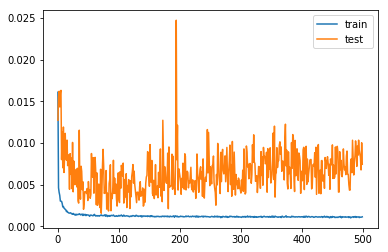

In [282]:
# 查看模型收敛状况
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.legend()
plt.show()

In [ ]:
# 评价模型质量
# def model_score(model,x_train,y_train,x_test,y_test):
#     trainScore = model.evaluate(x_train, y_train, verbose=0)
#     print('Train Score: %s MSE (%s RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))
#     testScore = model.evaluate(x_test, y_test, verbose=0)
#     print('Test Score: %s MSE (%s RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    
# model_score(model, x_train, y_train, x_test, y_test)

In [57]:
model.save('trained_model_stock_lstm_multiple_elements_%s' % ts_code)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: trained_model_stock_lstm_multiple_elements_600678.SH\assets


In [59]:
# 从硬盘取出模型
l = models.load_model('trained_model_stock_lstm_multiple_elements_%s' % ts_code)

In [62]:
test_predict_l=l.predict(x_test)
test_predict=model.predict(x_test)
test_predict == test_predict_l

array([[ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [

array([[False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       ...,
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False]])

In [271]:
# 预测数据
train_predict=model.predict(x_train)
test_predict=model.predict(x_test)
train_predict.shape,test_predict.shape

((3769, 1), (868, 1))

In [272]:
# 将结果组合成归一化之前的结构 方便后面还原数据
zero_train=np.zeros((train_predict.shape[0],train_data.shape[1]-1)) 
zero_test=np.zeros((test_predict.shape[0],train_data.shape[1]-1))
# 合并列，注意预测值放在最后列，因为当初归一化的时候y值就最后
train_predict=np.column_stack((zero_train,train_predict)) 
test_predict=np.column_stack((zero_test,test_predict))
train_predict.shape,test_predict.shape

((3769, 6), (868, 6))

In [273]:
# 数据还原
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)
train_predict

array([[1.14660000e+00, 1.17810000e+00, 1.13760000e+00, 1.14880000e+00,
        6.96216530e+03, 3.53185567e+00],
       [1.14660000e+00, 1.17810000e+00, 1.13760000e+00, 1.14880000e+00,
        6.96216530e+03, 3.53023217e+00],
       [1.14660000e+00, 1.17810000e+00, 1.13760000e+00, 1.14880000e+00,
        6.96216530e+03, 3.54927801e+00],
       ...,
       [1.14660000e+00, 1.17810000e+00, 1.13760000e+00, 1.14880000e+00,
        6.96216530e+03, 8.17208457e+00],
       [1.14660000e+00, 1.17810000e+00, 1.13760000e+00, 1.14880000e+00,
        6.96216530e+03, 8.15366052e+00],
       [1.14660000e+00, 1.17810000e+00, 1.13760000e+00, 1.14880000e+00,
        6.96216530e+03, 8.14525139e+00]])

In [274]:
print(train_predict[:,-1])

[3.53185567 3.53023217 3.54927801 ... 8.17208457 8.15366052 8.14525139]


In [275]:
# 计算还原后结果准确度标准差及变异系数。
train_rmse= math.sqrt(mean_squared_error(y_train,train_predict[:,-1]))
test_rmse=math.sqrt(mean_squared_error(y_test,test_predict[:,-1]))
avg=np.mean(list(df['moving_ndays_close'][-test_predict.shape[0]:]))
test_cv=test_rmse/avg
train_rmse,test_rmse,test_cv

(5.036249420778037, 10.502661896521037, 0.8623382380962343)

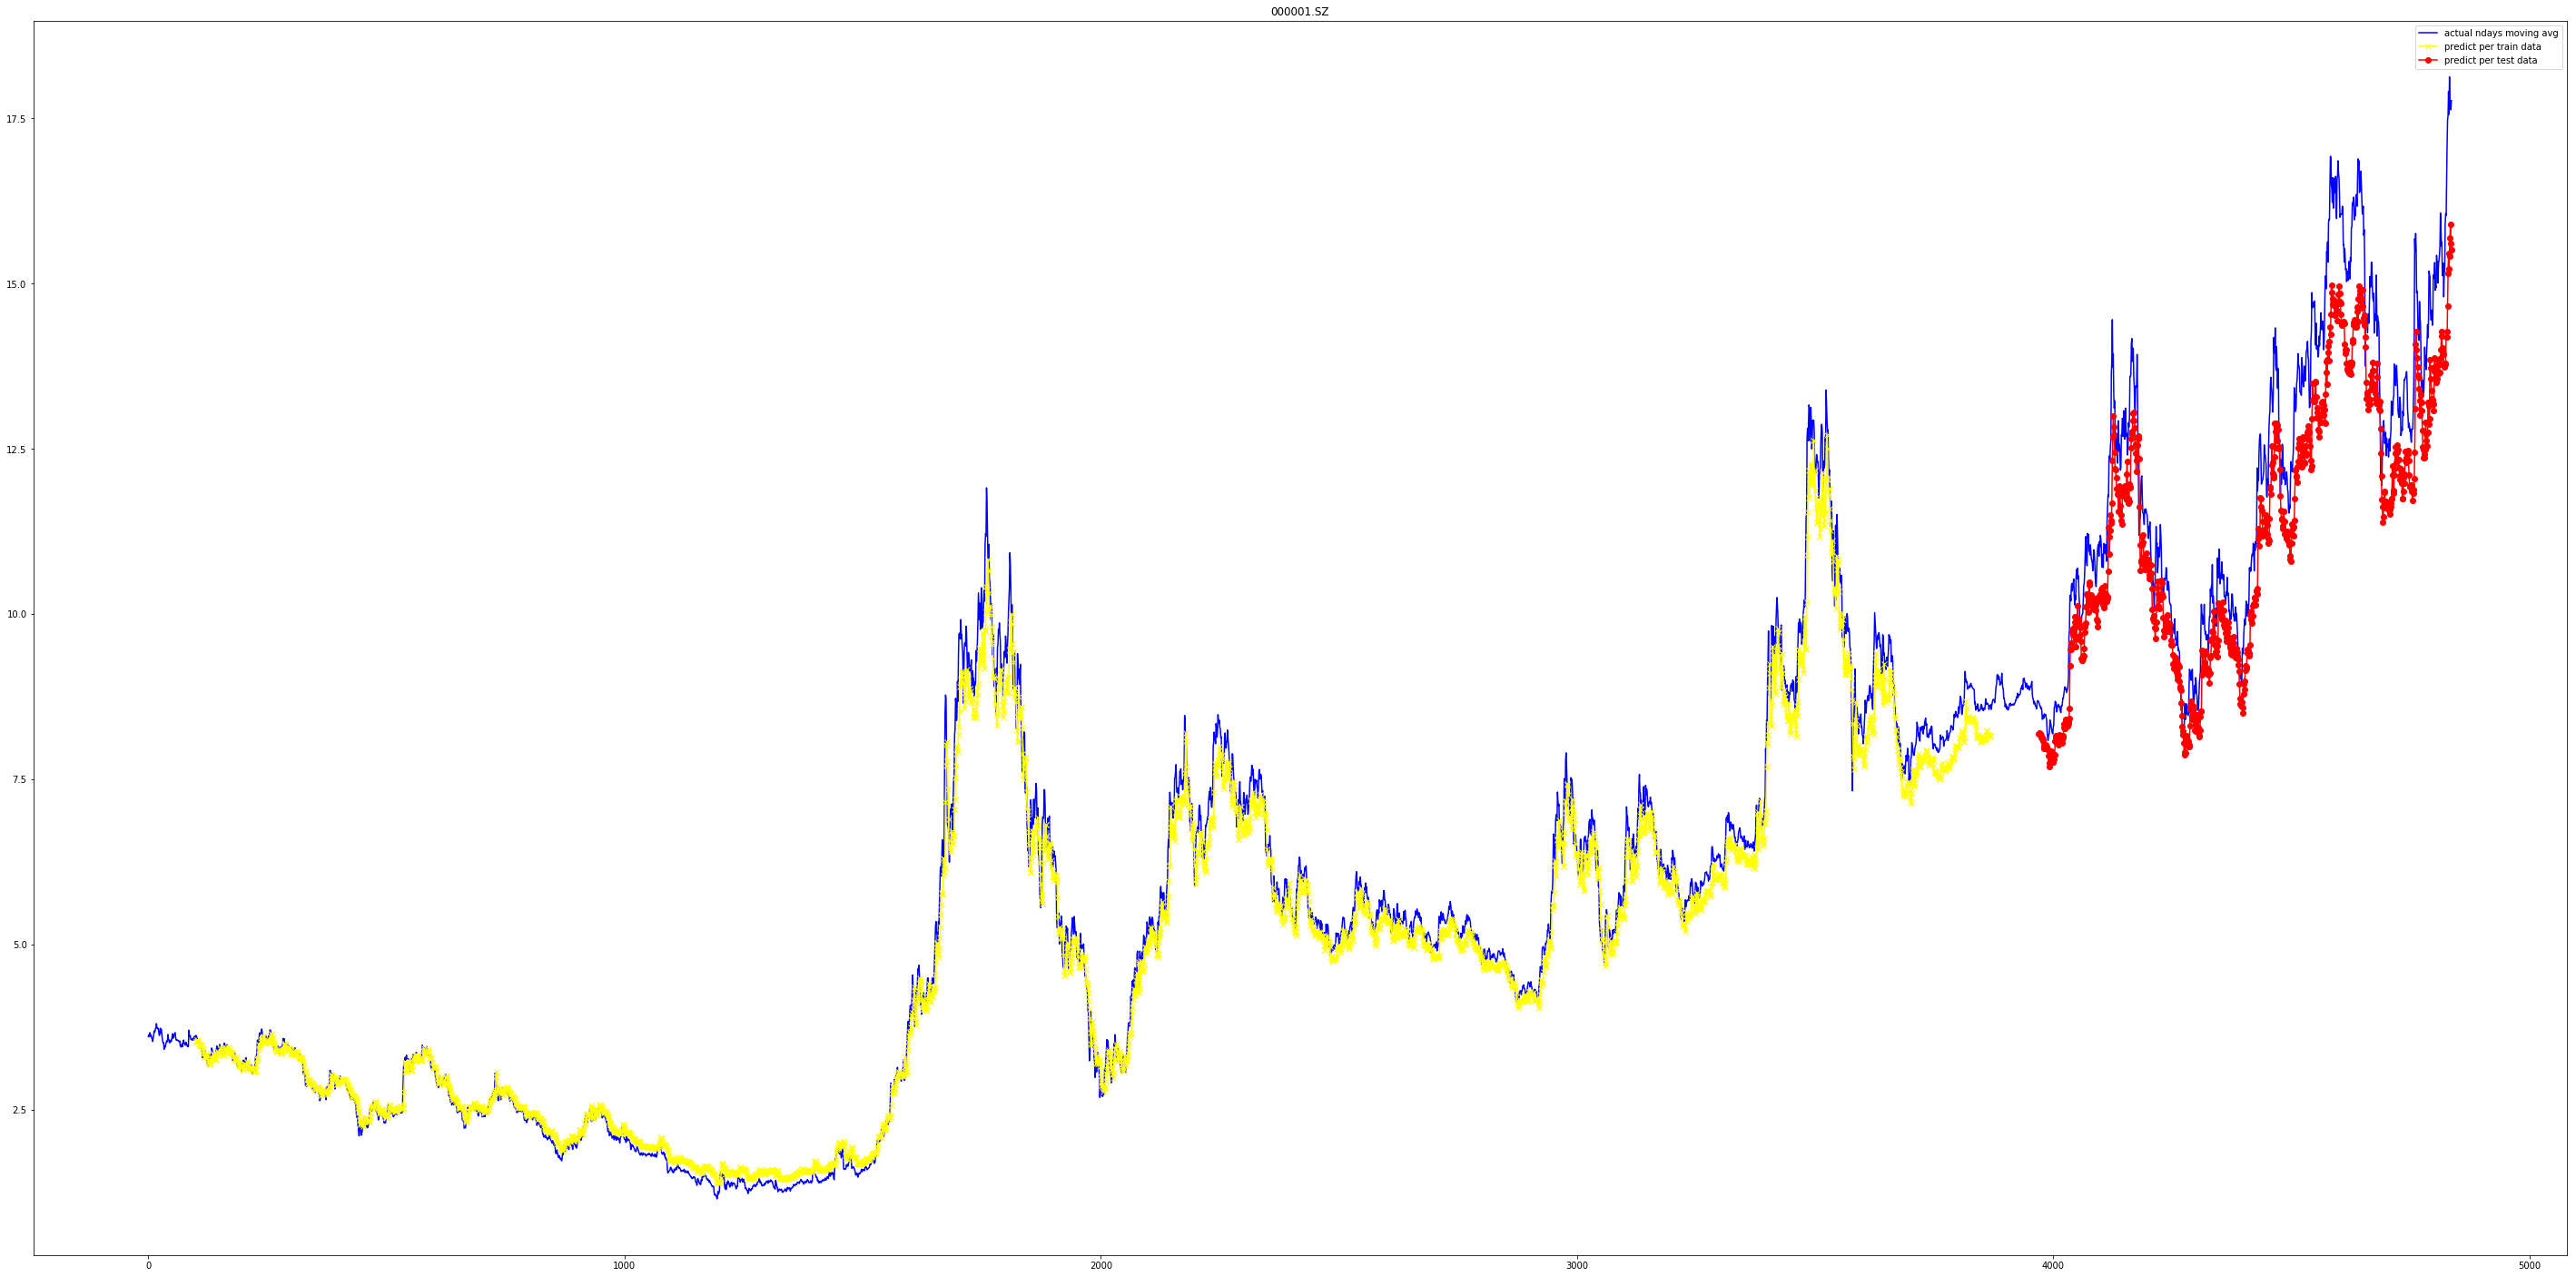

In [276]:
# 绘制计算结果图
trainPredictPlot=np.empty_like(df['moving_ndays_close'])
trainPredictPlot[:]=np.nan

trainPredictPlot[lookback:len(train_predict)+lookback]=train_predict[:,-1]

test_start_point=len(train_predict)+lookback*2 
testPredictPlot=np.empty_like(df['moving_ndays_close'])
testPredictPlot[:]=np.nan
# 测试值赋给一个列表，位置整体往后移动100*2
testPredictPlot[test_start_point:]=test_predict[:,-1]
plt.figure(figsize=(50,25))
# plt.plot(list(df['close']),c='blue',label="close data")
# plt.plot(list(df['close']),c='black',label="price")
plt.plot(list(df['moving_ndays_close']),c='blue',label="actual ndays moving avg")
plt.plot(trainPredictPlot,c='yellow',marker="x",label="predict per train data")
plt.plot(testPredictPlot,c='red',marker="o",label="predict per test data")
plt.title(ts_code)
plt.legend()
plt.show()

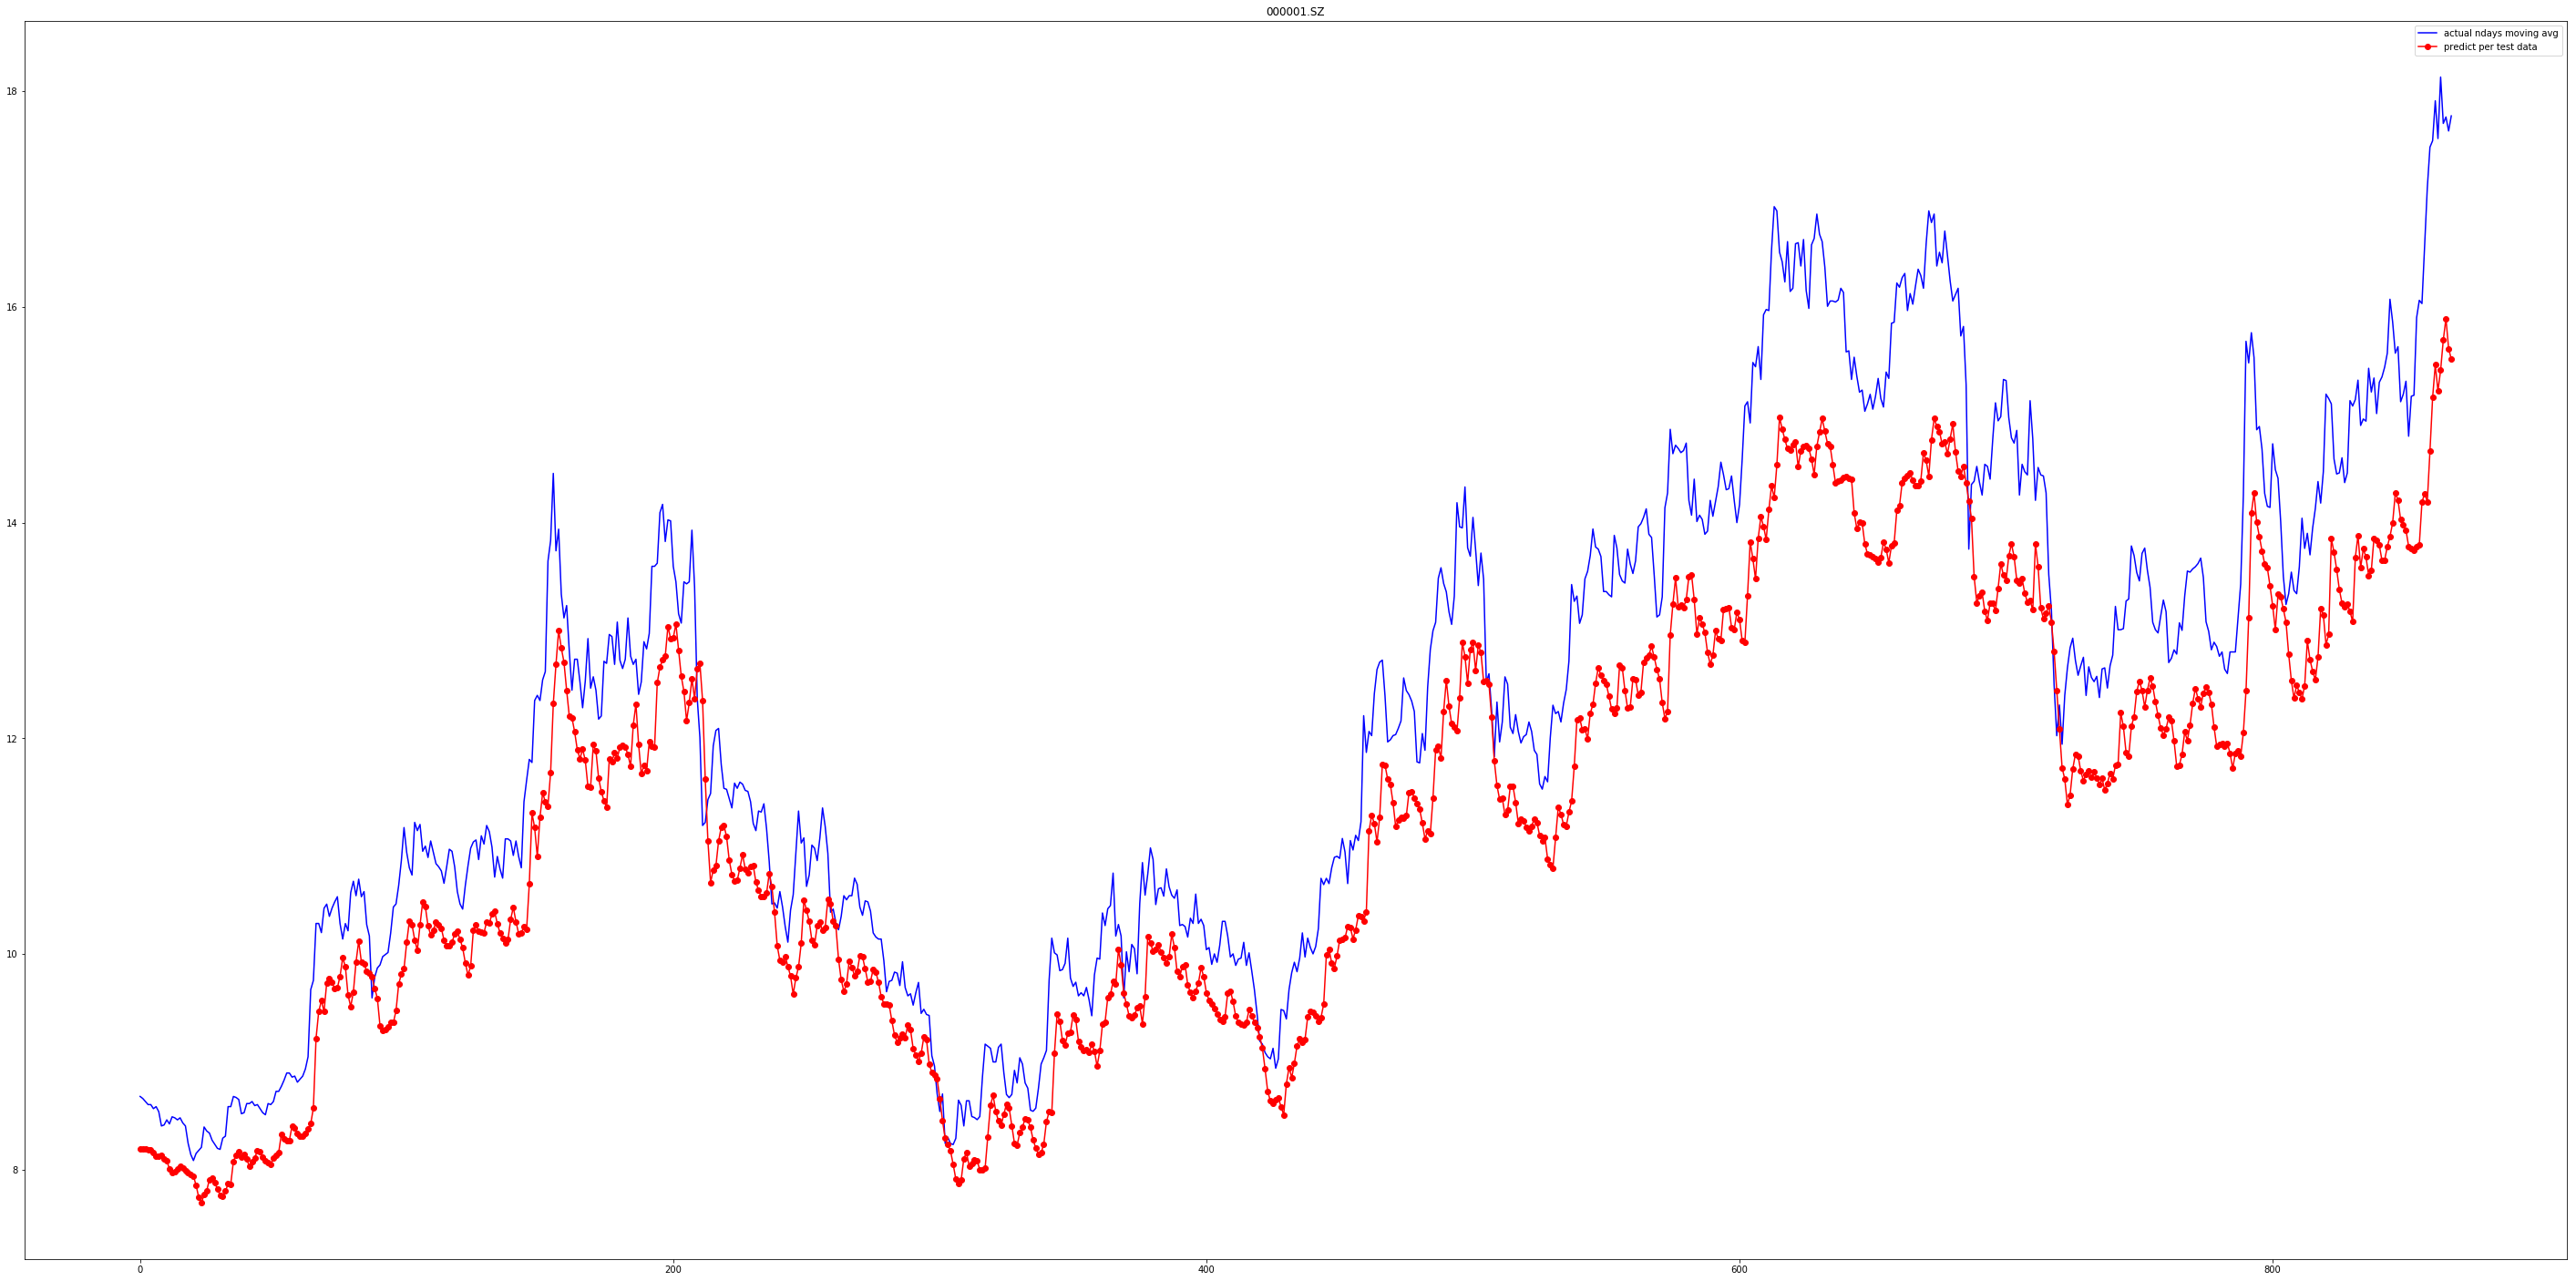

In [277]:
# 绘制测试集结果
plt.figure(figsize=(50,25))
plt.plot(list(df['moving_ndays_close'][-test_predict.shape[0]:]),c='blue',label="actual ndays moving avg")
plt.plot(test_predict[:,-1],c='red',marker="o",label="predict per test data")
plt.title(ts_code)
plt.legend()
plt.show()

In [264]:
def result_difference(test_predict, real_price):
    test_predict=np.array(test_predict)
    real_price=np.array(real_price)
    diff=[]
    for i in range(len(test_predict)):
        predit_price=round(test_predict[i],2)
        actual_price=round(real_price[i],2)
        price_diff=round(predit_price-actual_price,2)
        percentage_diff=round((predit_price-actual_price)/actual_price,2)
        diff.append([predit_price,actual_price,price_diff,percentage_diff])
    return np.array(diff)
p = result_difference(test_predict[:,-1], df['moving_ndays_close'][-test_predict.shape[0]:])
p

array([[ 8.690e+00,  8.680e+00,  1.000e-02,  0.000e+00],
       [ 8.680e+00,  8.660e+00,  2.000e-02,  0.000e+00],
       [ 8.680e+00,  8.630e+00,  5.000e-02,  1.000e-02],
       ...,
       [ 1.667e+01,  1.776e+01, -1.090e+00, -6.000e-02],
       [ 1.630e+01,  1.763e+01, -1.330e+00, -8.000e-02],
       [ 1.635e+01,  1.777e+01, -1.420e+00, -8.000e-02]])

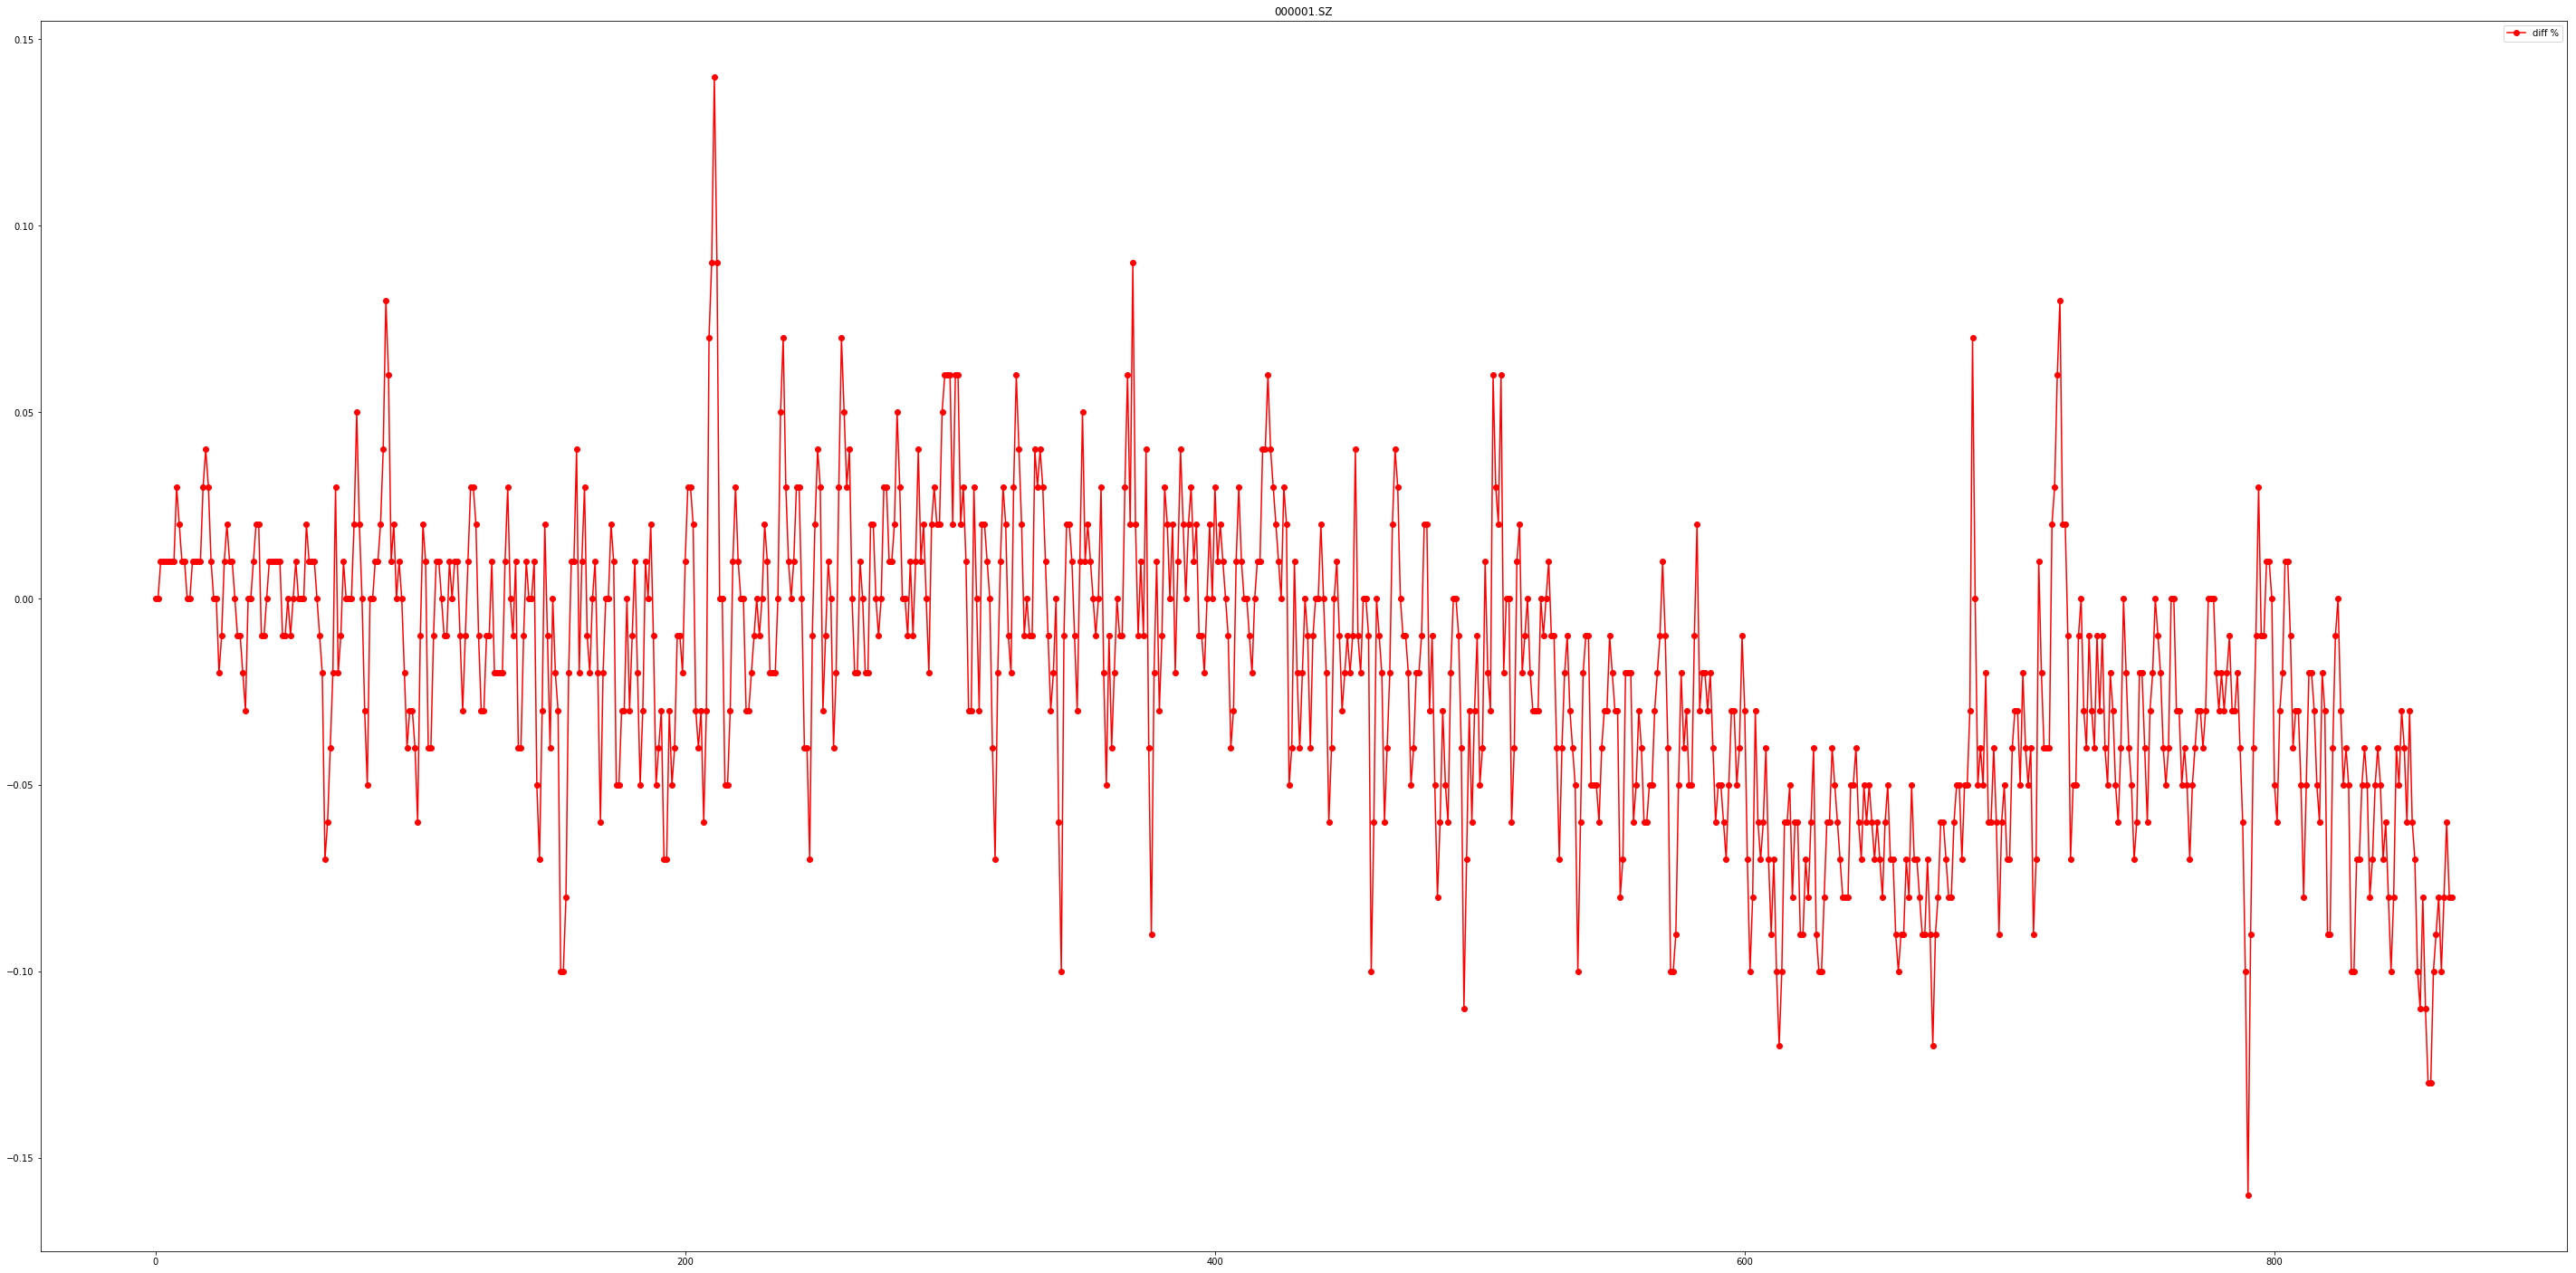

In [265]:
plt.figure(figsize=(50,25))
plt.plot(p[:,-1],c='red',marker="o",label="diff %")
plt.title(ts_code)
plt.legend()
plt.show()

In [65]:
a=datetime.datetime.strptime('20201105','%Y%m%d')
a=a + datetime.timedelta(days=1)
b = datetime.datetime.strftime(a,'%Y%m%d')
b 


'20201106'

In [14]:
r = df[df['trade_date'] == '20201029']
r
# r.iloc[0,5] 

,ts_code,trade_date,open,high,low,close,amount
1,600678.SH,20201029,6.12,6.25,6.05,6.19,29339.342


In [68]:
input_x=df[df['trade_date'] <= '20201029']
input_x= input_x.tail(100)
input_x.drop(['trade_date'],axis=1)
input_x

,trade_date,open,high,low,close,amount,moving_ndays_close
100,20200602,6.30,6.35,6.26,6.35,52473.019,6.274
99,20200603,6.37,6.39,6.26,6.27,51439.586,6.246
98,20200604,6.30,6.42,6.21,6.33,53246.499,6.228
97,20200605,6.33,6.34,6.20,6.24,38947.936,6.180
96,20200608,6.24,6.28,6.16,6.18,35625.159,6.146
95,20200609,6.20,6.21,6.15,6.21,24312.659,6.106
94,20200610,6.21,6.24,6.15,6.18,28868.971,6.088
93,20200611,6.17,6.21,6.08,6.09,44000.861,6.062
92,20200612,5.98,6.10,5.93,6.07,37687.725,6.062
91,20200615,6.07,6.09,5.97,5.98,40179.652,6.062


In [69]:
aaa= input_x.drop(['trade_date'],axis=1)
aaa

,open,high,low,close,amount,moving_ndays_close
100,6.30,6.35,6.26,6.35,52473.019,6.274
99,6.37,6.39,6.26,6.27,51439.586,6.246
98,6.30,6.42,6.21,6.33,53246.499,6.228
97,6.33,6.34,6.20,6.24,38947.936,6.180
96,6.24,6.28,6.16,6.18,35625.159,6.146
95,6.20,6.21,6.15,6.21,24312.659,6.106
94,6.21,6.24,6.15,6.18,28868.971,6.088
93,6.17,6.21,6.08,6.09,44000.861,6.062
92,5.98,6.10,5.93,6.07,37687.725,6.062
91,6.07,6.09,5.97,5.98,40179.652,6.062


In [70]:
aaa=scaler.transform(aaa)
aaa

array([[0.16699672, 0.16253007, 0.1751725 , 0.17172409, 0.02397522,
        0.17856499],
       [0.16919711, 0.16374821, 0.1751725 , 0.16916472, 0.0235018 ,
        0.17761574],
       [0.16699672, 0.16466181, 0.17353203, 0.17108424, 0.02432955,
        0.17700552],
       [0.16793975, 0.16222554, 0.17320393, 0.16820495, 0.01777938,
        0.17537824],
       [0.16511068, 0.16039833, 0.17189156, 0.16628543, 0.01625722,
        0.17422559],
       [0.16385332, 0.15826659, 0.17156346, 0.16724519, 0.01107496,
        0.17286952],
       [0.16416766, 0.15918019, 0.17156346, 0.16628543, 0.01316221,
        0.1722593 ],
       [0.16291029, 0.15826659, 0.16926681, 0.16340614, 0.02009412,
        0.17137785],
       [0.15693782, 0.15491671, 0.1643454 , 0.16276629, 0.01720208,
        0.17137785],
       [0.15976688, 0.15461218, 0.16565778, 0.159887  , 0.01834363,
        0.17137785],
       [0.15725216, 0.15583031, 0.16598587, 0.1643659 , 0.02427955,
        0.17178467],
       [0.16070991, 0

In [72]:
aaa.shape

(100, 6)

In [79]:
aaa=np.reshape(aaa,(1,aaa.shape[0], aaa.shape[1]))
aaa.shape

(1, 100, 6)

In [80]:
aaa

array([[[0.16699672, 0.16253007, 0.1751725 , 0.17172409, 0.02397522,
         0.17856499],
        [0.16919711, 0.16374821, 0.1751725 , 0.16916472, 0.0235018 ,
         0.17761574],
        [0.16699672, 0.16466181, 0.17353203, 0.17108424, 0.02432955,
         0.17700552],
        [0.16793975, 0.16222554, 0.17320393, 0.16820495, 0.01777938,
         0.17537824],
        [0.16511068, 0.16039833, 0.17189156, 0.16628543, 0.01625722,
         0.17422559],
        [0.16385332, 0.15826659, 0.17156346, 0.16724519, 0.01107496,
         0.17286952],
        [0.16416766, 0.15918019, 0.17156346, 0.16628543, 0.01316221,
         0.1722593 ],
        [0.16291029, 0.15826659, 0.16926681, 0.16340614, 0.02009412,
         0.17137785],
        [0.15693782, 0.15491671, 0.1643454 , 0.16276629, 0.01720208,
         0.17137785],
        [0.15976688, 0.15461218, 0.16565778, 0.159887  , 0.01834363,
         0.17137785],
        [0.15725216, 0.15583031, 0.16598587, 0.1643659 , 0.02427955,
         0.17178467],